In [3]:
# Import TF and TF Hub libraries.
import tensorflow as tf
import tensorflow_hub as hub

import splitfolders
import os

from PIL import Image
import numpy as np
from typing import Tuple
import cv2
import math

In [4]:
# Download the model from TF Hub.
model = hub.load("https://www.kaggle.com/models/google/movenet/TensorFlow2/singlepose-thunder/4")
movenet = model.signatures['serving_default']

In [5]:
DATA_DIR = 'data'

# map edges to a RGB color
KEYPOINT_EDGE_INDS_TO_COLOR = {
    (0, 1): (147, 20, 255),
    (0, 2): (255, 255, 0),
    (1, 3): (147, 20, 255),
    (2, 4): (255, 255, 0),
    (0, 5): (147, 20, 255),
    (0, 6): (255, 255, 0),
    (5, 7): (147, 20, 255),
    (7, 9): (147, 20, 255),
    (6, 8): (255, 255, 0),
    (8, 10): (255, 255, 0),
    (5, 6): (0, 255, 255),
    (5, 11): (147, 20, 255),
    (6, 12): (255, 255, 0),
    (11, 12): (0, 255, 255),
    (11, 13): (147, 20, 255),
    (13, 15): (147, 20, 255),
    (12, 14): (255, 255, 0),
    (14, 16): (255, 255, 0)
}

# A list of distictive colors
COLOR_LIST = [
    (47, 79, 79),
    (139, 69, 19),
    (0, 128, 0),
    (0, 0, 139),
    (255, 0, 0),
    (255, 215, 0),
    (0, 255, 0),
    (0, 255, 255),
    (255, 0, 255),
    (30, 144, 255),
    (255, 228, 181),
    (255, 105, 180),
]

## Test Out

In [6]:
# Load the input input_image.
image_path = 'ergonomis/DSC02413.JPG'
image = tf.io.read_file(os.path.join(DATA_DIR, image_path))
image = tf.compat.v1.image.decode_jpeg(image)
image = tf.expand_dims(image, axis=0)
# Resize and pad the input_image to keep the aspect ratio and fit the expected size.
image = tf.cast(tf.image.resize_with_pad(image, 256, 256), dtype=tf.int32)

The MoveNet output is a tensor of shape 1 x 1 x 17 x 3 because:

- The first dimension (1) represents the batch size, as you are only processing one image at a time.
- The second dimension (1) is not used and can be ignored.
- The third dimension (17) represents the 17 keypoints detected by MoveNet for a single pose.
- The fourth dimension (3) represents the y-coordinate, x-coordinate and confidence score of each keypoint.



In [7]:
# Run model inference.
outputs = movenet(image)
# Output is a [1, 1, 17, 3] tensor.
keypoints = outputs['output_0']

In [8]:
keypoints

<tf.Tensor: shape=(1, 1, 17, 3), dtype=float32, numpy=
array([[[[0.4510233 , 0.4667056 , 0.6246008 ],
         [0.43574762, 0.48341694, 0.40575892],
         [0.4343727 , 0.45474038, 0.49855983],
         [0.4443238 , 0.5127452 , 0.65773124],
         [0.44016328, 0.4435594 , 0.56650555],
         [0.515245  , 0.54746205, 0.6918683 ],
         [0.5153039 , 0.4133974 , 0.6520261 ],
         [0.62697285, 0.5538741 , 0.79344594],
         [0.6124348 , 0.363891  , 0.5237641 ],
         [0.6493232 , 0.47950867, 0.7455008 ],
         [0.63776964, 0.2935589 , 0.64152366],
         [0.7290338 , 0.50250286, 0.39001217],
         [0.71789485, 0.41503233, 0.5088232 ],
         [0.76067734, 0.52169734, 0.01483185],
         [0.8051755 , 0.40014538, 0.01586398],
         [0.8151393 , 0.4902058 , 0.0214395 ],
         [0.8190458 , 0.421173  , 0.01555509]]]], dtype=float32)>

In [35]:
def visualize(
        input_image: np.ndarray,
        person_keypoints: np.ndarray,
        keypoint_color: Tuple[int, ...] = COLOR_LIST,
        keypoint_threshold: float = 0.05,
        instance_threshold: float = 0.1,
) -> np.ndarray:
    """Draws landmarks and edges on the input input_image and return it.
  
    Args:
      input_image: The input RGB input_image.
      person_keypoints: The list of keypoints.
      keypoint_color: the colors in which the landmarks should be plotted.
      keypoint_threshold: minimum confidence score for a keypoint to be drawn.
      instance_threshold: minimum confidence score for a person to be drawn.
  
    Returns:
      Image with keypoints and edges.
    """

    # Draw all the landmarks
    for i in range(len(person_keypoints)):
        if person_keypoints[i,2] >= keypoint_threshold:
            # unnormalize the keypoint from 256x256 image
            center = (int(person_keypoints[i,1] * 256), int(person_keypoints[i,0] * 256))
            cv2.circle(input_image, center, 2, (0, 255, 0), 4)

    # Draw all the edges
    for edge_pair, edge_color in KEYPOINT_EDGE_INDS_TO_COLOR.items():
        if (person_keypoints[edge_pair[0],2] > keypoint_threshold and
                person_keypoints[edge_pair[1],2] > keypoint_threshold):
            pt1 = person_keypoints[edge_pair[0],[1,0]] * 256
            pt2 = person_keypoints[edge_pair[1],[1,0]] * 256
            print(pt1, pt2)
            cv2.line(input_image, pt1.astype(int), pt2.astype(int), edge_color, 2)

    return input_image

In [36]:
image_with_keypoints = visualize(image.numpy()[0], keypoints.numpy()[0,0])

[119.47663 115.46197] [123.75474 111.55139]
[119.47663 115.46197] [116.413536 111.19941 ]
[123.75474 111.55139] [131.26277  113.746895]
[116.413536 111.19941 ] [113.55121 112.6818 ]
[119.47663 115.46197] [140.15028 131.90273]
[119.47663 115.46197] [105.829735 131.9178  ]
[140.15028 131.90273] [141.79176 160.50505]
[141.79176 160.50505] [122.75422 166.22675]
[105.829735 131.9178  ] [ 93.1561  156.78331]
[ 93.1561  156.78331] [ 75.15108 163.26903]
[140.15028 131.90273] [105.829735 131.9178  ]
[140.15028 131.90273] [128.64073 186.63266]
[105.829735 131.9178  ] [106.248276 183.78108 ]
[128.64073 186.63266] [106.248276 183.78108 ]


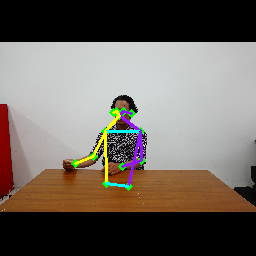

In [37]:
# display the image in the notebook
# Convert image to uint8
image_with_keypoints_uint8 = cv2.convertScaleAbs(image_with_keypoints)
Image.fromarray(image_with_keypoints_uint8)